In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

## seq2seq
### Генерация имён

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

n samples =  7944
5 examples:  ['charil', 'siffre', 'jeannine', 'ranique', 'curt']
max length = 16


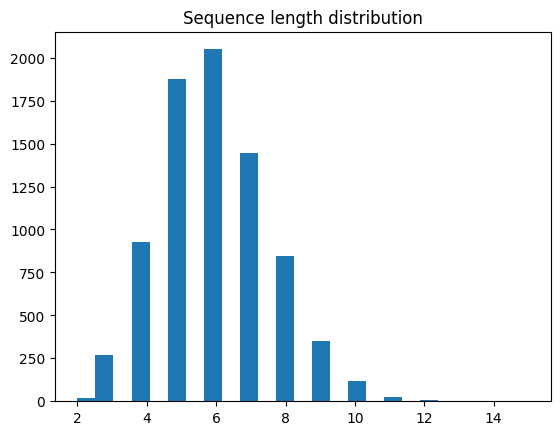

In [27]:
with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [line for line in names]

for i in range(len(names)):
    names[i] = names[i].lower()

print('n samples = ',len(names))
print("5 examples: ", random.sample(names, 5))

MAX_LENGTH = max(map(len, names)) + 1
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25)
plt.show()

In [4]:
tokens = set()
for name in names:
    tokens.update(set(name))

tokens = sorted(list(tokens))
# tokens = list(tokens)

NUM_TOKENS = len(tokens)
print(NUM_TOKENS, '\n', tokens)

tokens.append('<') # <SOS>
tokens.append('>') # <EOS>
tokens.append('_') # <PAD>
NUM_TOKENS+=3

token_to_id = {token: idx for idx, token in enumerate(tokens)}
print(token_to_id)

29 
 [' ', "'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{' ': 0, "'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '<': 29, '>': 30, '_': 31}


In [10]:
from keras.utils import to_categorical

def to_matrix(names, max_len=None, dtype='int64', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or (max(map(len, names)) + 1)
    names_ix = np.zeros([len(names), max_len], dtype=dtype) + token_to_id['_']
    names_ix[:, 0] = token_to_id['<'] # <SOS>

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, 1:len(line_ix)] = line_ix[1:]
        names_ix[i, len(line_ix)] = token_to_id['>'] # <EOS>

    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

def create_target(names, dtype='int64'):
    # Shift each element in 'names' one position to the left
    target = np.roll(names, shift=-1, axis=1)

    # Replace the last element in each row with the token ID for '<EOS>' (End of Sequence)
    target[:, -1] = token_to_id['_']  # <EOS> token

    # Flatten the 2D 'target' tensor into a 1D array
    target_flat = target.flatten()

    # Convert the flattened array into a one-hot encoded representation
    # The number of classes is specified by 'NUM_TOKENS'
    target_categorical = to_categorical(target_flat, num_classes=NUM_TOKENS)

    # Reshape the one-hot encoded array back to the original 2D shape with an additional dimension
    # The additional dimension corresponds to the one-hot encoding for each token
    target_categorical = target_categorical.reshape(target.shape + (NUM_TOKENS,))

    # Return the resulting 3D tensor representing the one-hot encoded targets
    return target_categorical

names_test_set = random.sample(names, 5)
print('\n'.join(names_test_set))
data_test_set = to_matrix(names_test_set, max_len=MAX_LENGTH)
print(data_test_set, '\n')
print(create_target(data_test_set)[0][0:3])

dolly
dody
adrianne
page
kara-lynn
[[29 17 14 14 27 30 31 31 31 31 31 31 31 31 31 31]
 [29 17  6 27 30 31 31 31 31 31 31 31 31 31 31 31]
 [29  6 20 11  3 16 16  7 30 31 31 31 31 31 31 31]
 [29  3  9  7 30 31 31 31 31 31 31 31 31 31 31 31]
 [29  3 20  3  2 14 27 16 16 30 31 31 31 31 31 31]] 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
# proportion of validation set
VAL_SPLIT = 0.2
x_data = to_matrix(names, max_len=MAX_LENGTH)
y_data = create_target(x_data)

# Split the data into training and validation sets
split_idx = int(len(x_data) * (1 - VAL_SPLIT))
x_train, x_val = x_data[:split_idx], x_data[split_idx:]
y_train, y_val = y_data[:split_idx], y_data[split_idx:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(6355, 16) (6355, 16, 32)
(1589, 16) (1589, 16, 32)


In [12]:
import tensorflow as tf
from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

In [13]:
def model_1():
    optimizer = Adam(learning_rate=0.001)
    model = models.Sequential()
    model.add(layers.Embedding(
                    input_dim=NUM_TOKENS,
                    output_dim=32,
                    input_length=MAX_LENGTH))
    model.add(layers.LSTM(
                    units=128,
                    return_sequences=True))
    model.add(layers.LSTM(
                    units=64,
                    return_sequences=True))
    model.add(layers.Dense(
                    units=NUM_TOKENS,
                    activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

Epoch 1/8
199/199 [==============================] - 39s 110ms/step - loss: 1.3767 - accuracy: 0.6427 - val_loss: 1.0861 - val_accuracy: 0.7065
Epoch 2/8
199/199 [==============================] - 19s 98ms/step - loss: 0.9964 - accuracy: 0.7040 - val_loss: 1.0046 - val_accuracy: 0.7085
Epoch 3/8
199/199 [==============================] - 18s 89ms/step - loss: 0.9204 - accuracy: 0.7220 - val_loss: 0.9493 - val_accuracy: 0.7184
Epoch 4/8
199/199 [==============================] - 18s 92ms/step - loss: 0.8770 - accuracy: 0.7296 - val_loss: 0.9299 - val_accuracy: 0.7213
Epoch 5/8
199/199 [==============================] - 17s 84ms/step - loss: 0.8649 - accuracy: 0.7313 - val_loss: 0.9235 - val_accuracy: 0.7232
Epoch 6/8
199/199 [==============================] - 15s 75ms/step - loss: 0.8545 - accuracy: 0.7334 - val_loss: 0.9234 - val_accuracy: 0.7227
Epoch 7/8
199/199 [==============================] - 15s 78ms/step - loss: 0.8451 - accuracy: 0.7356 - val_loss: 0.9069 - val_accuracy: 0.728

INFO:tensorflow:Assets written to: model.rnn/assets


50/50 [==============================] - 2s 32ms/step - loss: 0.9043 - accuracy: 0.7234
Accuracy: 72.34%


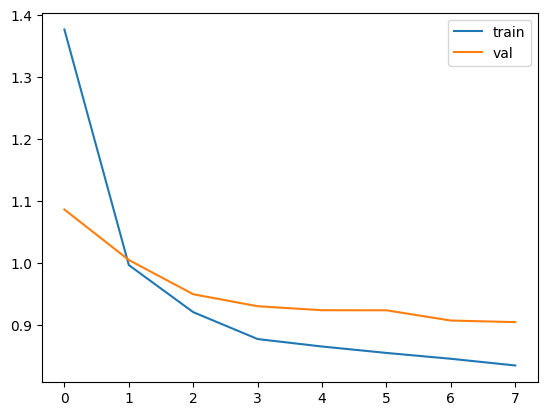

In [28]:
model = model_1()

history = model.fit(
        x_train,
        y_train,
        epochs=8,
        batch_size=32,
        validation_split=VAL_SPLIT,
        validation_data=(x_val, y_val))

model.save("model.rnn")

print("Accuracy: %.2f%%" % (model.evaluate(x_val, y_val)[1]*100))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

Epoch 1/12
100/100 [==============================] - 14s 68ms/step - loss: 1.7507 - accuracy: 0.6148 - val_loss: 1.2553 - val_accuracy: 0.6468
Epoch 2/12
100/100 [==============================] - 6s 64ms/step - loss: 1.1942 - accuracy: 0.6474 - val_loss: 1.1304 - val_accuracy: 0.6957
Epoch 3/12
100/100 [==============================] - 8s 82ms/step - loss: 1.0236 - accuracy: 0.7051 - val_loss: 1.0106 - val_accuracy: 0.7196
Epoch 4/12
100/100 [==============================] - 8s 81ms/step - loss: 0.9628 - accuracy: 0.7164 - val_loss: 0.9905 - val_accuracy: 0.7293
Epoch 5/12
100/100 [==============================] - 8s 82ms/step - loss: 0.9177 - accuracy: 0.7273 - val_loss: 0.9668 - val_accuracy: 0.7275
Epoch 6/12
100/100 [==============================] - 6s 58ms/step - loss: 0.8902 - accuracy: 0.7297 - val_loss: 0.9444 - val_accuracy: 0.7183
Epoch 7/12
100/100 [==============================] - 8s 77ms/step - loss: 0.8760 - accuracy: 0.7297 - val_loss: 0.9324 - val_accuracy: 0.722

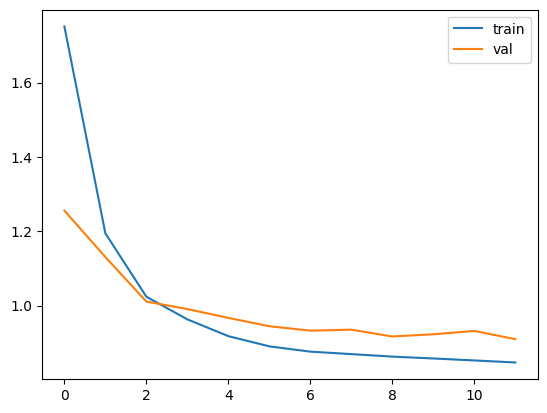

In [18]:
def model_2():
    optimizer = Adam(learning_rate=0.00075)
    model = models.Sequential()
    model.add(layers.Embedding(
                    input_dim=NUM_TOKENS,
                    output_dim=32,
                    input_length=MAX_LENGTH))
    model.add(layers.LSTM(
                    units=128,
                    return_sequences=True))
    model.add(layers.LSTM(
                    units=64,
                    return_sequences=True))
    model.add(layers.Dense(
                    units=64,
                    activation='relu'))
    model.add(layers.Dense(
                    units=NUM_TOKENS,
                    activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

model2 = model_2()

history = model2.fit(
        x_train,
        y_train,
        epochs=12,
        batch_size=64,
        validation_split=VAL_SPLIT,
        validation_data=(x_val, y_val))

print("Accuracy: %.2f%%" % (model2.evaluate(x_val, y_val)[1]*100))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [29]:
# model = models.load_model("model.rnn")

def generate_sample(model, seed_phrase='<', max_length=MAX_LENGTH, temperature=1.0):
    generated_sequence = seed_phrase.lower()

    while len(generated_sequence) < max_length:
        seed_matrix = to_matrix([generated_sequence], max_len=max_length)

        probabilities = model.predict(seed_matrix, verbose=0)[0][len(generated_sequence) - 1]
        
        probabilities = np.log(probabilities) / temperature
        exp_probabilities = np.exp(probabilities)
        probabilities = exp_probabilities / np.sum(exp_probabilities)
        next_token_index = np.random.choice(len(probabilities), p=probabilities)
        next_token = tokens[next_token_index]

        generated_sequence += next_token

        if next_token == '>':
            break

    generated_sequence = generated_sequence[0] + generated_sequence[1].upper() + generated_sequence[2:]
    return generated_sequence

for t in [0.2, 0.5, 1.2, 2.0]:
    print('temperature = ', t)
    for i in range(3):
        print('\t', generate_sample(model, temperature=t))
    for i in range(3):
        print('\t', generate_sample(model, seed_phrase='<Red', temperature=t))
    

temperature =  0.2
	 <Arelie>
	 <Arin>
	 <Arin>
	 <Redie>
	 <Redia>
	 <Redie>
temperature =  0.5
	 <Arel>
	 <Arelin>
	 <Aree>
	 <Redine>
	 <Red>
	 <Redin>
temperature =  1.2
	 <Hgina>
	 <Il>
	 <Sry>
	 <Redbamik>
	 <Redei>
	 <Redie>
temperature =  2.0
	 <Mn>
	 <Arla_>
	 <Xuplet>
	 <Redanl>
	 <Redilin-ry>
	 <Redrbino>


In [30]:
for t in [0.2, 0.5, 1.2, 2.0]:
    print('temperature = ', t)
    for i in range(3):
        print('\t', generate_sample(model2, temperature=t))
    for i in range(3):
        print('\t', generate_sample(model2, seed_phrase='<Y', temperature=t))

temperature =  0.2
	 <Ara>
	 <Arie>
	 <Arin>
	 <Yren>
	 <Ynn>
	 <Yne>
temperature =  0.5
	 <Vene>
	 <Ole>
	 <Erat>
	 <Yla>
	 <Ylle>
	 <Yle>
temperature =  1.2
	 <Aricela>
	 <Ansdomlo>
	 <Ambyrte>
	 <Ypanerdyr>
	 <Ynd>
	 <Ylna>
temperature =  2.0
	 <Zcjenlmana>
	 <Lrarlkdj>
	 <Lmeelci>
	 <Yrle-akdsatygeu
	 <Ybegr>
	 <Ynaste>
